# Preprocessing & Modeling

## Libraries

In [131]:
#working in the dataframes 
import pandas as pd
import numpy as np
from collections import Counter

#graphing 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#using nlp 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
nltk.download('words')

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

#interpretation on the models 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from itertools import cycle
from scipy import interp
import scoring as sc
from tqdm import tqdm
import string
import re
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\clair\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Load in Datasets

### Summary statistics
Summary statistics refer to numerical measures that provide a concise overview of a dataset

In [134]:
#Read in the data
df_flights = pd.read_csv('../data/flights_cleaned.csv')
#Check to see if it worked
df_flights.head()

,subreddit,text
0,Flights,"$9AUD Flight To date, I just purchased my chea..."
1,Flights,I'm an engineer with a design to reverse engin...
2,Flights,TAP AIR FLIGHT SONG
3,Flights,what would you do? awful rule regarding Porter...
4,Flights,EVA Air CC Verification


In [135]:
df_hotels = pd.read_csv('../data/hotels_cleaned.csv')
#Check to see if it worked
df_hotels.head()

,subreddit,text
0,hotels,Double booking + egregious hotel cancellation ...
1,hotels,Hotel Managment Hello All! \nI am currently ap...
2,hotels,Parking pass
3,hotels,A Journey Through The Oceana Hotel Culinary Wo...
4,hotels,Chime Card at Las Vegas Hotels


In [136]:
df_flights.describe().T

,count,unique,top,freq
subreddit,4959,2,Flights,4933
text,4959,4959,"$9AUD Flight To date, I just purchased my chea...",1


In [137]:
df_hotels.describe().T

,count,unique,top,freq
subreddit,4767,1,hotels,4767
text,4767,4767,Double booking + egregious hotel cancellation ...,1


In [138]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4959 entries, 0 to 4958
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4959 non-null   object
 1   text       4959 non-null   object
dtypes: object(2)
memory usage: 77.6+ KB


In [139]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4767 entries, 0 to 4766
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4767 non-null   object
 1   text       4767 non-null   object
dtypes: object(2)
memory usage: 74.6+ KB


In [140]:
#  exploring patterns in the text to assess how best to cleanse the data
pat_list = [r'\d', '-', '\+', ':', '!', '\?', '\.', '\\n'] # list of special characters/punctuation to search for in data

def punc_search(df, col, pat):
    """
    function that counts the number of narratives
    that contain a pre-defined list of special
    characters and punctuation
    """
    for p in pat:
        v = df[col].str.contains(p).sum() # total n_rows that contain the pattern
        print(f'{p} special character is present in {v} entries')



In [141]:
punc_search(df_flights, 'text', pat_list)

\d special character is present in 2413 entries
- special character is present in 2402 entries
\+ special character is present in 143 entries
: special character is present in 831 entries
! special character is present in 825 entries
\? special character is present in 3233 entries
\. special character is present in 3047 entries
\n special character is present in 1873 entries


In [142]:
punc_search(df_hotels, 'text', pat_list)

\d special character is present in 849 entries
- special character is present in 2793 entries
\+ special character is present in 33 entries
: special character is present in 325 entries
! special character is present in 183 entries
\? special character is present in 434 entries
\. special character is present in 687 entries
\n special character is present in 194 entries


In [143]:
def keep_english_words(text):
    doc = nlp(text)
    english_words = [token.text for token in doc if token.is_alpha and token.lang_ == "en"]
    return " ".join(english_words)

In [144]:
df_flights["text"] = df_flights["text"].apply(keep_english_words)
df_flights = df_flights[df_flights["text"] != ""]

In [145]:
df_flights

,subreddit,text
0,Flights,Flight To date I just purchased my cheapest in...
1,Flights,I an engineer with a design to reverse enginee...
2,Flights,TAP AIR FLIGHT SONG
3,Flights,what would you do awful rule regarding Porter ...
4,Flights,EVA Air CC Verification
...,...,...
4954,Flights,Do children need ID to travel domestically I j...
4955,Flights,UÇUŞ RÖTARINDA TAZMİNAT ALMAK
4956,Flights,Help figuring out a flight to Bulgaria Hi just...
4957,Flights,Is this a bait and switch by Southwest deleted


### remove non-english words

In [146]:
def removeNonEnglishWordsFunct(x):
    words = set(nltk.corpus.words.words())
    filteredSentence = " ".join(w for w in nltk.wordpunct_tokenize(x) \
                                if w.lower() in words or not w.isalpha())
    return filteredSentence

In [147]:
df_flights["text"] = df_flights["text"].apply(removeNonEnglishWordsFunct)
df_flights = df_flights[df_flights["text"] != ""]

In [148]:
df_hotels["text"] = df_hotels["text"].apply(removeNonEnglishWordsFunct)
df_hotels = df_hotels[df_hotels["text"] != ""]

<Figure size 1600x1600 with 0 Axes>

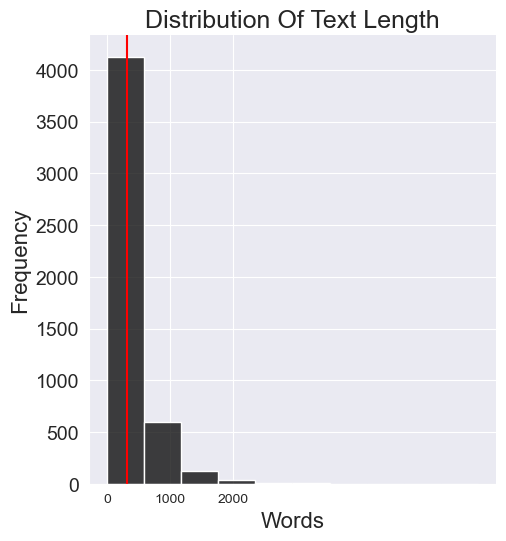

In [149]:
# Generating a list of text lengths

lengths = [len(text) for text in df_flights["text"]]

# Plotting the text lengths

plt.figure(figsize = (16,16), facecolor = "white")
sns.displot(lengths, kde = False, bins = 10, color = "black")
plt.axvline(np.mean(lengths), color = "red")
plt.title("Distribution Of Text Length", size = 18)
plt.xlabel("Words", size = 16)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,2550,1000),size =10)
plt.yticks(size = 14);

# The red line marks the mean length

In [155]:
def plot_most_frequent_words(dataframes, titles):
    
    # The count inidcates where in the subplot to go
    count = 0
    fig   = plt.figure(figsize   = (24,20),
                       facecolor = "white")
    
    # Enumerating allows for the list of titles to be referenced
    for d, dataframe in enumerate(dataframes):
        
        # Updating the location
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        
        # Creating the graph
        sns.barplot(x       = 0,
                    y       = dataframe.index,
                    data    = dataframe,
                    palette = "deep")
        
        # Setting the graph parameters
        plt.title(f"Most Common Words From {titles[d]}", size = 20)
        plt.xlabel("Number Of Occurences", size = 18)
        plt.ylabel("Word", size = 18)
        plt.xticks(size = 16)
        plt.yticks(size=25)

## Count vectorizer

CountVectorizer is a feature extraction technique used in Natural Language Processing (NLP) to convert a collection of text documents to a matrix of token counts. It is a common technique used for text classification, sentiment analysis, and topic modeling.

In CountVectorizer, each document is represented as a vector of token counts, where each token represents a word in the document vocabulary. The number of times a token appears in a document is counted and stored in the corresponding element of the vector. For example, consider the following two documents:

CountVectorizer also includes several optional parameters, such as n-gram range, minimum document frequency, and maximum document frequency, which can be used to customize the vectorization process and improve the accuracy of the machine learning model.

In [153]:
# Instantiating the count vectorizer

vectorizer = CountVectorizer()

# Masking the vectorizer with English stop words

cvec_flights     = CountVectorizer(stop_words = "english")
cvec_hotels = CountVectorizer(stop_words = "english")

# Subsetting the dataframe

flights     = df_flights[df_flights["subreddit"]  == 'Flights']
hotels = df_hotels[df_hotels["subreddit"] == 'hotels']

# Fit-transforming the vectorizer

vec_flights     = cvec_flights.fit_transform(flights["text"])
vec_hotels = cvec_hotels.fit_transform(hotels["text"])

C:\Users\clair\miniconda3\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\clair\miniconda3\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


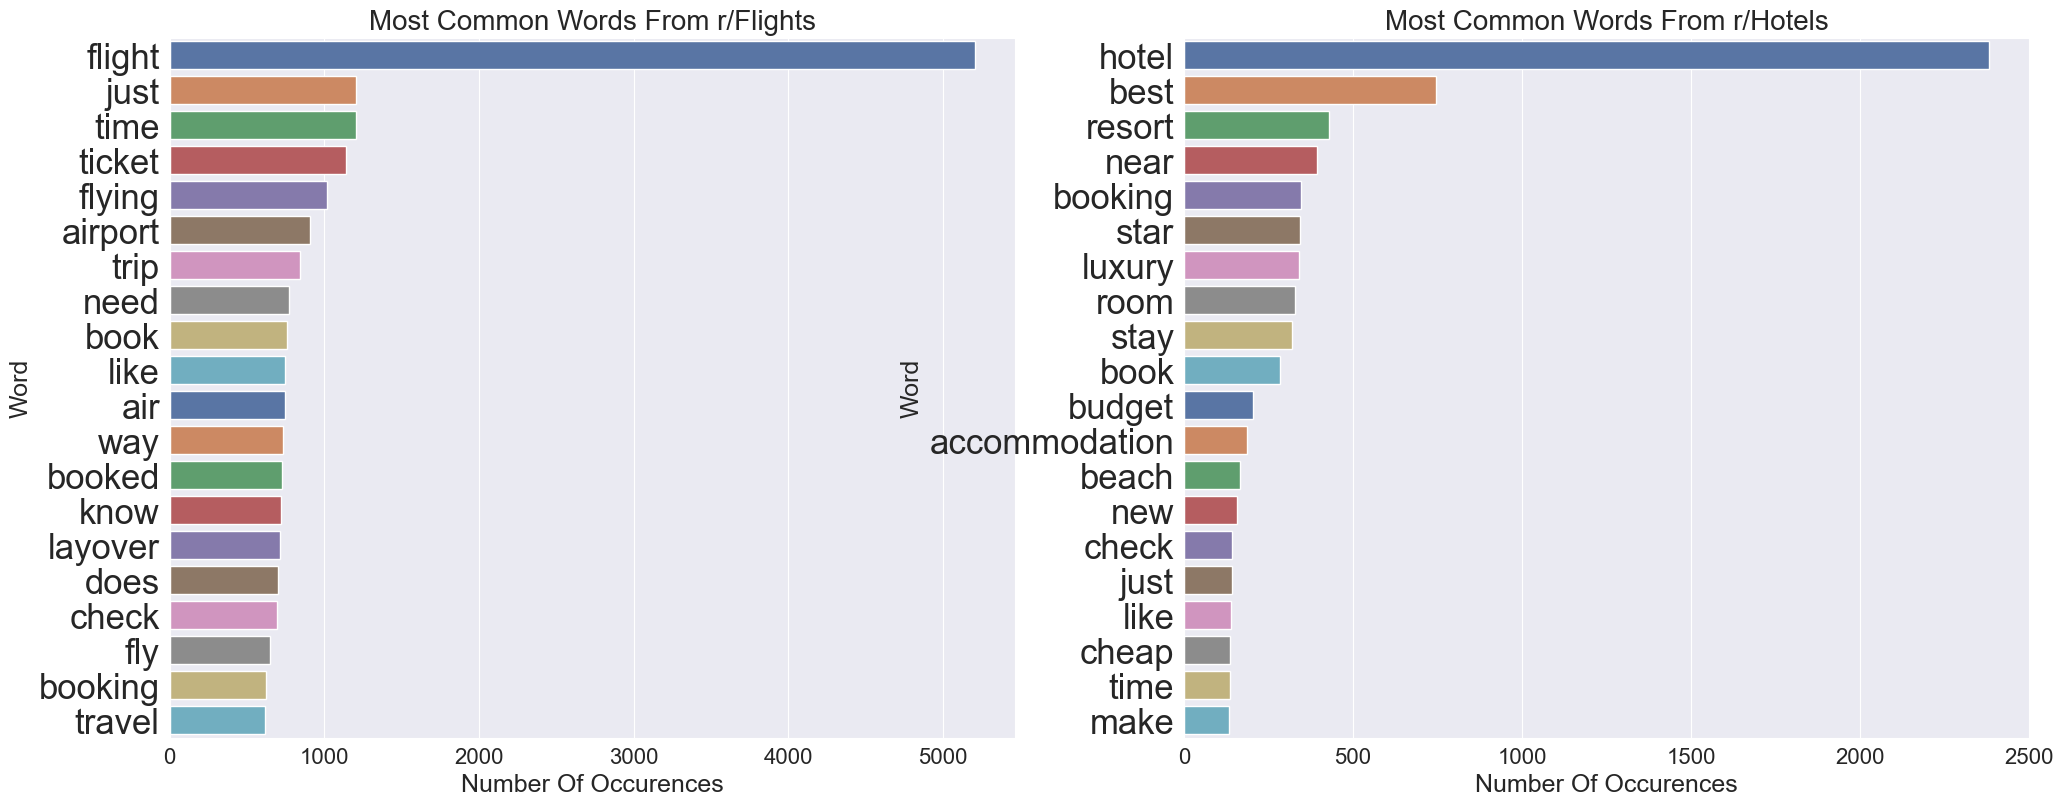

In [156]:
# Saving the vectorized dfs to a new dataframe

flights_vectorized     = pd.DataFrame(vec_flights.toarray(), 
                                      columns = cvec_flights.get_feature_names())
hotels_vectorized = pd.DataFrame(vec_hotels.toarray(), 
                                      columns = cvec_hotels.get_feature_names())

# Getting the 15 most frequent words from each

vectorized_flights     = pd.DataFrame(flights_vectorized.sum().sort_values(ascending = False).head(20))
vectorized_hotels = pd.DataFrame(hotels_vectorized.sum().sort_values(ascending = False).head(20))

# Plotting the most common words

plot_most_frequent_words(dataframes = [vectorized_flights, 
                                       vectorized_hotels],
                         titles     = ["r/Flights", 
                                       "r/Hotels"])



We can see that there are a lot of words that occur in both subreddits. We decided that we should create a list of customized stop words. Furthermore, we noticed that we must lemmatize or stem the text columns because of there are multiple forms of words in the most frequent words such as 'fly' & 'flying' or 'ticket' and 'tickets'. the straight words words like flights hotels we plance to remove as well



## Stopwords

Stopwords are often removed from text data before processing it for natural language processing (NLP) tasks such as text classification, sentiment analysis, and topic modeling. This is because they can interfere with the accuracy and efficiency of these tasks by increasing the noise-to-signal ratio in the text data.

In [21]:
# Downloading the default stopwords

nltk.download("stopwords");

# Adding our stopwords to the English set

new_stopwords = ["book", "flight", "hotel", "book", 
                 "just", "time", "like",
                 "resort","airline","fly"]

stopwords     = stopwords.words('english')

stopwords.extend(new_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\clair\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Tokenize Lemmatize

Tokenization is the process of breaking a sequence of text into smaller units called tokens. In natural language processing, tokens are usually words or subwords that are used to represent the text data.

Lemmatizing is the process of reducing a word to its base or root form, which is called the lemma. In linguistics, a lemma is the canonical form of a word, which represents its core meaning. For example, the lemma of the word "running" is "run", and the lemma of the word "better" is "good".

In [22]:
# Instantiating the lemmatizier and tokenizer
# The tokenizer will only keep text

lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

# Setting up the lemmatizer

lemmatized_posts = []

def lemma(df):
    for post in df["text"]:
        tokens = tokenizer.tokenize(post)
        post   = [lemmatizer.lemmatize(post) for post in tokens]
        lemmatized_posts.append(" ".join(post))
    return lemmatized_posts
    


In [23]:
lemmatized_posts = []
lemma(df_flights)

# Appending the lemmatized posts to the dataframe

df_flights["lemmatized_text"] = lemmatized_posts

# Checking the head of the dataframe

df_flights = df_flights.drop('text', axis=1)
df_flights.head()

C:\Users\clair\AppData\Local\Temp\ipykernel_18620\3754048542.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights["lemmatized_text"] = lemmatized_posts


,subreddit,lemmatized_text
0,Flights,Flight To date I just my international flight ...
1,Flights,I an engineer with a design to reverse enginee...
2,Flights,TAP AIR FLIGHT SONG
3,Flights,what would you do awful rule regarding Porter ...
4,Flights,Air Verification


In [24]:
lemmatized_posts = []
lemma(df_hotels)

# Appending the lemmatized posts to the dataframe

df_hotels["lemmatized_text"] = lemmatized_posts

# Checking the head of the dataframe


df_hotels = df_hotels.drop('text', axis=1)
df_hotels.head()

,subreddit,lemmatized_text
0,hotels,Double booking egregious hotel cancellation po...
1,hotels,Hotel Hello All I am currently for assistant m...
2,hotels,Parking pas
3,hotels,A Journey Through The Hotel Culinary Wonderland
4,hotels,Chime Card at Las


## Stemming

Stemming is a natural language processing technique used to reduce a word to its root or base form, known as a "stem." This technique is commonly used in search engines, information retrieval systems, and other text analysis applications to improve information retrieval and search results.

In [25]:
#changing our lemmatized_text to a lower case and split the posts into indvidual words
df_flights['lemmatized_text'] = df_flights['lemmatized_text'].str.lower().str.split()  

In [26]:
df_hotels['lemmatized_text'] = df_hotels['lemmatized_text'].str.lower().str.split()  

In [27]:
#Instantiate object of class PorterStemmer.
p_stemmer = PorterStemmer()

In [28]:
# Define a function to stemmatize text data 

def stemmatize_data(data, col_list):
    p_stemmer = PorterStemmer()
    for col in col_list:
        stemmed_items = []
        for row in data[col]:
            stemmed_row = [p_stemmer.stem(word) for word in row]
            stemmed_items.append(stemmed_row)
        data[f'stemmatized_{col}'] = stemmed_items
    return data 

In [29]:
# Stemmatize submissions text data 
col_list_text =['lemmatized_text']
df_flights = stemmatize_data(df_flights, col_list_text)

In [30]:
df_flights = df_flights.drop('lemmatized_text', axis=1)
df_flights.head()

,subreddit,stemmatized_lemmatized_text
0,Flights,"[flight, to, date, i, just, my, intern, flight..."
1,Flights,"[i, an, engin, with, a, design, to, revers, en..."
2,Flights,"[tap, air, flight, song]"
3,Flights,"[what, would, you, do, aw, rule, regard, porte..."
4,Flights,"[air, verif]"


In [31]:
df_hotels = stemmatize_data(df_hotels, col_list_text)
df_hotels = df_hotels.drop('lemmatized_text', axis=1)
df_hotels.head()

,subreddit,stemmatized_lemmatized_text
0,hotels,"[doubl, book, egregi, hotel, cancel, polici, h..."
1,hotels,"[hotel, hello, all, i, am, current, for, assis..."
2,hotels,"[park, pa]"
3,hotels,"[a, journey, through, the, hotel, culinari, wo..."
4,hotels,"[chime, card, at, la]"


In [32]:
punc_search(df_hotels, 'stemmatized_lemmatized_text', pat_list)

\d special character is present in 0.0 entries
- special character is present in 0.0 entries
\+ special character is present in 0.0 entries
: special character is present in 0.0 entries
! special character is present in 0.0 entries
\? special character is present in 0.0 entries
\. special character is present in 0.0 entries
\n special character is present in 0.0 entries


In [33]:
punc_search(df_flights, 'stemmatized_lemmatized_text', pat_list)

\d special character is present in 0.0 entries
- special character is present in 0.0 entries
\+ special character is present in 0.0 entries
: special character is present in 0.0 entries
! special character is present in 0.0 entries
\? special character is present in 0.0 entries
\. special character is present in 0.0 entries
\n special character is present in 0.0 entries


In [34]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4725 entries, 0 to 4766
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   subreddit                    4725 non-null   object
 1   stemmatized_lemmatized_text  4725 non-null   object
dtypes: object(2)
memory usage: 110.7+ KB


In [35]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4895 entries, 0 to 4958
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   subreddit                    4895 non-null   object
 1   stemmatized_lemmatized_text  4895 non-null   object
dtypes: object(2)
memory usage: 114.7+ KB


#### both dataframe has similar number of count so they are quite balance

In [36]:
# Using pandas.concat() to concat two DataFrames
data = [df_hotels, df_flights]
df = pd.concat(data)
print(df)

     subreddit                        stemmatized_lemmatized_text
0       hotels  [doubl, book, egregi, hotel, cancel, polici, h...
1       hotels  [hotel, hello, all, i, am, current, for, assis...
2       hotels                                         [park, pa]
3       hotels  [a, journey, through, the, hotel, culinari, wo...
4       hotels                              [chime, card, at, la]
...        ...                                                ...
4953   Flights  [are, alway, high, around, and, do, you, think...
4954   Flights  [do, need, id, to, travel, domest, i, just, bo...
4956   Flights  [help, out, a, flight, to, hi, just, found, th...
4957   Flights     [is, thi, a, bait, and, switch, by, southwest]
4958   Flights  [fli, to, transfer, flight, in, nervou, about,...

[9620 rows x 2 columns]


In [37]:
df[df['subreddit']== 'u_Eagle-Flights-India']

,subreddit,stemmatized_lemmatized_text
957,u_Eagle-Flights-India,"[who, work, in, collabor, are, more, satisfi, ..."
1048,u_Eagle-Flights-India,"[how, are, team, build, compani, cultur]"
1238,u_Eagle-Flights-India,"[how, virtual, team, are, and, their, impact, ..."
1329,u_Eagle-Flights-India,"[give, a, up, to, your, employe, product, with..."
1330,u_Eagle-Flights-India,"[give, a, up, to, your, employe, product, with..."
1331,u_Eagle-Flights-India,"[give, a, up, to, your, employe, product, with..."
1332,u_Eagle-Flights-India,"[give, a, up, to, your, employe, product, with..."
1353,u_Eagle-Flights-India,"[implement, these, to, build, a, success, busi..."
1421,u_Eagle-Flights-India,"[how, are, team, build, give, competit, advant..."
1483,u_Eagle-Flights-India,"[experienti, the, new, age, corpor, learn, pla..."


In [38]:
df.drop(df[df['subreddit'].str.contains('u_Eagle-Flights-India')].index, inplace=True)

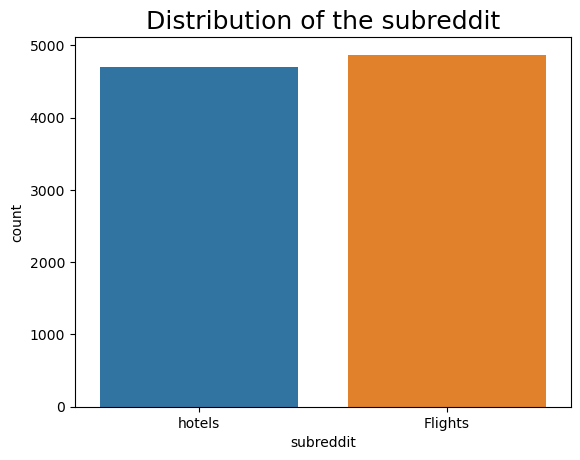

In [39]:

sns.countplot(x=df["subreddit"])
plt.title("Distribution of the subreddit", fontsize = 18); #title


In [159]:
#save a copy of the df
df = df.to_csv('../data/df.csv', index = False)

In [160]:
#Read in the data
df = pd.read_csv('../data/df.csv')
#Check to see if it worked
df.head()

,subreddit,stemmatized_lemmatized_text
0,hotels,"['doubl', 'book', 'egregi', 'hotel', 'cancel',..."
1,hotels,"['hotel', 'hello', 'all', 'i', 'am', 'current'..."
2,hotels,"['park', 'pa']"
3,hotels,"['a', 'journey', 'through', 'the', 'hotel', 'c..."
4,hotels,"['chime', 'card', 'at', 'la']"


### Text vectorisation
Models cannot interpret words. Instead, the words have to be converted into numbers using a process known as vectorisation.

In [194]:
texts = df['stemmatized_lemmatized_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['subreddit'].values #target

print (X.shape)
print(y.shape)

(9568, 35554)
(9568,)


In [162]:
X

<9568x35554 sparse matrix of type '<class 'numpy.float64'>'
	with 458215 stored elements in Compressed Sparse Row format>

In [163]:
#Dimenionality reduction. Only using the 100 best features er category

#lsa = TruncatedSVD(n_components=100, 
 #                  n_iter=10, 
  #                 random_state=42)
#
#X = lsa.fit_transform(X)
#X.shape

In [164]:
X

<9568x35554 sparse matrix of type '<class 'numpy.float64'>'
	with 458215 stored elements in Compressed Sparse Row format>

In [165]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'LogisticRegression': LogisticRegression(random_state=42),
              'Multinomial Naive Bayes': MultinomialNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

## Train-test split

In [166]:
#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3,  # 70% train 30% test
                                                    shuffle = True, # shuffles data prior to splitting
                                                    stratify = y, # distribution of classes across train and test
                                                    random_state = 3)# ensures same split each time to allow repeatability

In [167]:
X_train

<6697x35554 sparse matrix of type '<class 'numpy.float64'>'
	with 316268 stored elements in Compressed Sparse Row format>

In [210]:
#Function to get the scores for each model in a df
def model_score_df(df):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(df).reset_index

<bound method DataFrame.reset_index of                 model_name accuracy_score precision_score recall_score  \
2       LogisticRegression       0.946708        0.946665     0.946772   
0            Random Forest       0.924765        0.924805     0.924679   
1           Decsision Tree       0.914316        0.914289     0.914289   
3  Multinomial Naive Bayes       0.914316        0.921528     0.913187   
4       K Nearest Neighbor       0.524208        0.730167      0.53245   

   f1_score  
2  0.946699  
0  0.924731  
1  0.914289  
3  0.913767  
4  0.400303  >

### LogisticRegression  Confusion Matrix

The confusion matrix we will create our true values and predicted values.

Getting our testing predictions



In [169]:
rf_best_model = RandomForestClassifier(bootstrap = False,
                                       max_depth = 50,
                                       max_features = 'auto',
                                       min_samples_leaf = 1,
                                       n_estimators = 1400,
                                       random_state=3)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


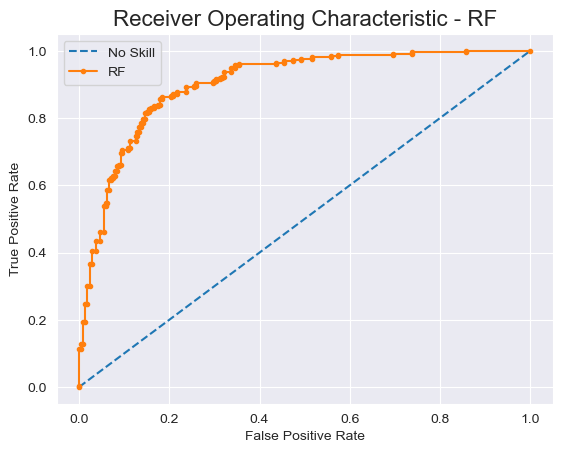

In [176]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RF')
# axis labels
plt.title('Receiver Operating Characteristic - RF', fontsize = 16)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [177]:
#Confusion Matrix - RF

#Fit the training data
rf_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = rf_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['business','scitech'], 
                     columns = ['business','scitech'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Random Forest \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

C:\Users\clair\miniconda3\envs\dsi-sg\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


KeyboardInterrupt: 

### Instantiatie RandomForestClassifier



In [179]:
#trying find the best split point in our fetaures
rf = RandomForestClassifier(random_state = 42)


In [181]:
#got our parameters by trial and error
rf_params = {
    'n_estimators': [110, 150],
    'max_depth': [None, 4, 6],
    'criterion': ['gini']
}

Transform to GridSearchCV



In [182]:
gs_2 = GridSearchCV(rf, param_grid=rf_params, cv=5)

Fit the model



In [184]:
gs_2.fit(X_train, y_train);


Obtaining the best estimator and parameters



In [186]:
print(gs_2.best_score_) 
gs_2.best_params_

0.9171259460724756


{'criterion': 'gini', 'max_depth': None, 'n_estimators': 110}

In [187]:
# Save best model as gs_model.
gs_model_2 = gs_2.best_estimator_

Accuracy training score

In [189]:
gs_model_2.score(X_train, y_train)

0.998058832312976

Accuracy testing score

In [191]:
gs_model_2.score(X_test, y_test)

0.92511320097527

In [ ]:
overfitting

In [214]:
gs_2.fit_transform(X_train.post_lm)

AttributeError: 'GridSearchCV' object has no attribute 'fit_transform'